In [1]:
# Apply fairness-aware data re-sampling (inspired by Ekstrand et al.) on lastfm-nl dataset for RecBole
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# 1. Load user profile, label interactions and plays interactions
user_df = pd.read_csv('../Post-processing/datasets/lastfm-nl/lastfm-nl.user', sep='\t')  # user_id:token, gender, age, etc.
inter_df_label = pd.read_csv('../datasets/split_datasets/lastfm-nl/lastfm-nl.train.inter', sep='\t')  # user_id:token, artist_id:token, label
inter_df_plays = pd.read_csv('../Post-processing/datasets/lastfm-nl/lastfm-nl.inter', sep='\t')  # user_id:token, artist_id:token, plays

# 2. Merge plays into train.inter
inter_df = inter_df_label.merge(
    inter_df_plays[['user_id:token', 'artist_id:token', 'plays:float']],
    how='left',
    left_on=['user_id:token', 'artist_id:token'],
    right_on=['user_id:token', 'artist_id:token']
)

# 3. Merge gender info
merged_df = inter_df.merge(
    user_df[['user_id:token', 'gender:token']],
    on='user_id:token',
    how='left'
)

merged_df.rename(columns={'gender:token': 'gender'}, inplace=True)

display(merged_df.head())

,user_id:token,artist_id:token,label:float,plays:float,gender
0,7db20cb306f5c6ee0a7da4b2eabbb12f80a4577d,c7e90641-f441-4801-8e4a-d09e10f452b8,1.0,166,M
1,7db20cb306f5c6ee0a7da4b2eabbb12f80a4577d,41489644-58f8-47e7-a581-e24d5659baeb,1.0,458,M
2,7db20cb306f5c6ee0a7da4b2eabbb12f80a4577d,609e7afd-3552-4102-9501-7611858ea320,1.0,176,M
3,7db20cb306f5c6ee0a7da4b2eabbb12f80a4577d,5251b5a0-3e3b-4d07-a152-585009575310,1.0,193,M
4,7db20cb306f5c6ee0a7da4b2eabbb12f80a4577d,5f6ab597-f57a-40da-be9e-adad48708203,1.0,402,M


In [2]:
# 4. Check gender distribution
female_df = merged_df[merged_df['gender'] == 'F']
male_df = merged_df[merged_df['gender'] == 'M']

female_user_count = female_df['user_id:token'].nunique()
female_positive = female_df[female_df['label:float'] == 1]
female_negative = female_df[female_df['label:float'] == 0]
female_interactions = len(female_df)
print(f"Female users: {female_user_count}, Female interactions: {female_interactions}")
print(f"Female interactions per user: {female_interactions / female_user_count:.4f}")
print(f"Female positive interactions: {len(female_positive)}")
print(f"Female positive ratio: {len(female_positive) / female_interactions:.4f}")

male_user_count = male_df['user_id:token'].nunique()
male_positive = male_df[male_df['label:float'] == 1]
male_negative = male_df[male_df['label:float'] == 0]
male_interactions = len(male_df)
print(f"Male users: {male_user_count}, Male interactions: {male_interactions}")
print(f"Male interactions per user: {male_interactions / male_user_count:.4f}")
print(f"Male positive interactions: {len(male_positive)}")
print(f"Male positive ratio: {len(male_positive) / male_interactions:.4f}")

Female users: 1733, Female interactions: 69381
Female interactions per user: 40.0352
Female positive interactions: 68880
Female positive ratio: 0.9928
Male users: 7059, Male interactions: 287033
Male interactions per user: 40.6620
Male positive interactions: 285760
Male positive ratio: 0.9956


In [3]:
# 5. Balance male/female interactions (undersample male group)
undersample_amount = male_user_count * (female_interactions / female_user_count)
positive_sample = min(int(undersample_amount * (len(female_positive) / female_interactions)), len(male_positive))
negtive_sample = min(int(undersample_amount * (1 - len(female_positive) / female_interactions)), male_interactions - len(male_positive))
print("if undersample male group:")
print(f"Need to sample {undersample_amount:.4f} male interactions.")
print(f"Need to sample {positive_sample} positive male interactions.")
print(f"Need to sample {negtive_sample} negative male interactions.")
male_positive_sampled = male_positive.sample(n=positive_sample, random_state=42)
male_negative_sampled = male_negative.sample(n=negtive_sample, random_state=42)

df_fair = pd.concat([female_df, male_positive_sampled, male_negative_sampled], ignore_index=True)

if downsample male group:
Need to sample 282608.4703 male interactions.
Need to sample 280567 positive male interactions.
Need to sample 1273 negative male interactions.


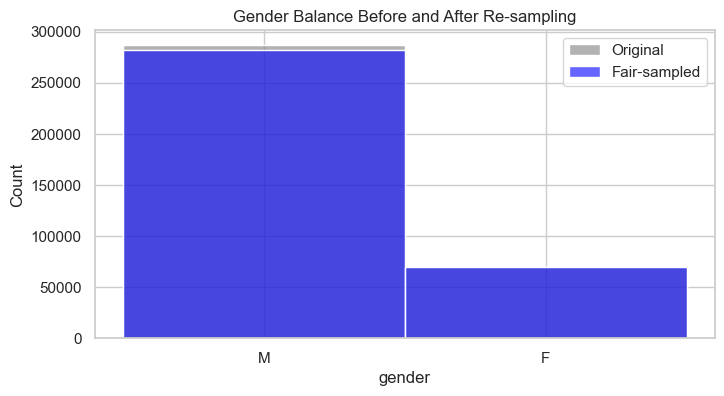

,user_id:token,artist_id:token,label:float,plays:float,gender
0,2218f28af05c0884229581e07bd34f2a60673b3f,90218af4-4d58-4821-8d41-2ee295ebbe21,1.0,120,F
1,5708fa50881f76e25c9c11beb0d091d50fd289f6,40f5d9e4-2de7-4f2d-ad41-e31a9a9fea27,1.0,691,F
2,09dc0ce70cd86880ecfbc1a21a52e2d97b7a373b,83d91898-7763-47d7-b03b-b92132375c47,1.0,32,F
3,09d9d04b2cbfe1788694ab7d16c9d3623fbcd8b8,9328a5f4-d710-488b-806b-68fb80d8c228,1.0,140,M
4,bc44ff4e465cace72e4fbfd03ce249a977f49b02,c3da3346-2643-48a7-93cd-011f6834b3d7,1.0,38,M


In [4]:
#shuffle balanced groups
df_fair = df_fair.sample(frac=1, random_state=42).reset_index(drop=True)

# 7. Optional: plot before and after
plt.figure(figsize=(8, 4))
sns.histplot(data=merged_df, x="gender", stat="count", color="gray", label="Original", alpha=0.6)
sns.histplot(data=df_fair, x="gender", stat="count", color="blue", label="Fair-sampled", alpha=0.6)
plt.title("Gender Balance Before and After Re-sampling")
plt.legend()
plt.show()

display(df_fair.head())

In [5]:
# 8. Save undersampled interaction set
import os

save_path = 'datasets/lastfm-nl/lastfm-nl.train.inter'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# 保存
df_fair[['user_id:token', 'artist_id:token','label:float']].to_csv(
    save_path,
    sep='\t',
    index=False
)
print(f"✅ Fair undersampled dataset saved to {save_path}")

✅ Fair resampled dataset saved to datasets/lastfm-nl/lastfm-nl.train.inter


In [6]:
import shutil

src_path = '../datasets/split_datasets/lastfm-nl/lastfm-nl.valid.inter'
dst_dir = 'datasets/lastfm-nl'
dst_path = os.path.join(dst_dir, 'lastfm-nl.valid.inter')

os.makedirs(dst_dir, exist_ok=True)

# 复制文件
shutil.copyfile(src_path, dst_path)

print(f"✅ File copied to {dst_path}")

src_path = '../datasets/split_datasets/lastfm-nl/lastfm-nl.test.inter'
dst_path = os.path.join(dst_dir, 'lastfm-nl.test.inter')

# 复制文件
shutil.copyfile(src_path, dst_path)

print(f"✅ File copied to {dst_path}")

✅ File copied to datasets/lastfm-nl/lastfm-nl.valid.inter
✅ File copied to datasets/lastfm-nl/lastfm-nl.test.inter


In [7]:
from recbole.quick_start import run_recbole

run_recbole(config_file_list=['lastfm-nl-undersample.yaml'])

10 Jun 16:46    INFO  ['/Users/huangjiaqing/Desktop/Recommender Systems/RScode/.venv/lib/python3.10/site-packages/ipykernel_launcher.py', '-f', '/Users/huangjiaqing/Library/Jupyter/runtime/kernel-33ddf9f8-d3fd-4514-b816-255326409bff.json']
10 Jun 16:46    INFO  
General Hyper Parameters:
gpu_id = 0
use_gpu = True
seed = 42
state = INFO
reproducibility = True
data_path = datasets/lastfm-nl
checkpoint_dir = checkpoint_saved/lastfm-nl/
show_progress = False
save_dataset = True
dataset_save_path = None
save_dataloaders = True
dataloaders_save_path = None
log_wandb = True

Training Hyper Parameters:
epochs = 100
train_batch_size = 1024
learner = adam
learning_rate = 0.0005
train_neg_sample_args = {'distribution': 'uniform', 'sample_num': 1, 'alpha': 1.0, 'dynamic': False, 'candidate_num': 0}
eval_step = 1
stopping_step = 10
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'split': {'RS': [0.8, 0.1, 0.1]}, 'order': 'RO', 'group_by': '

10 Jun 16:46    INFO  epoch 0 training [time: 2.87s, train loss: 237.3201]
10 Jun 16:46    INFO  epoch 0 evaluating [time: 12.38s, valid_score: 0.030500]
10 Jun 16:46    INFO  valid result: 
precision@10 : 0.0166    recall@10 : 0.0376    hit@10 : 0.1514    ndcg@10 : 0.0305    itemcoverage@10 : 0.0732    averagepopularity@10 : 1150.4424    shannonentropy@10 : 0.0012    giniindex@10 : 0.9973    tailpercentage@10 : 0.0045
10 Jun 16:46    INFO  Saving current: checkpoint_saved/lastfm-nl/BPR-Jun-10-2025_16-46-40.pth
10 Jun 16:46    INFO  epoch 1 training [time: 2.82s, train loss: 201.0489]
10 Jun 16:47    INFO  epoch 1 evaluating [time: 10.90s, valid_score: 0.029700]
10 Jun 16:47    INFO  valid result: 
precision@10 : 0.0159    recall@10 : 0.036    hit@10 : 0.1451    ndcg@10 : 0.0297    itemcoverage@10 : 0.013    averagepopularity@10 : 1228.9768    shannonentropy@10 : 0.0053    giniindex@10 : 0.9996    tailpercentage@10 : 0.0009
10 Jun 16:47    INFO  epoch 2 training [time: 2.71s, train los

{'best_valid_score': 0.0623,
 'valid_score_bigger': True,
 'best_valid_result': OrderedDict([('precision@10', 0.035),
              ('recall@10', 0.0796),
              ('hit@10', 0.3046),
              ('ndcg@10', 0.0623),
              ('itemcoverage@10', 0.1743),
              ('averagepopularity@10', 545.078),
              ('shannonentropy@10', 0.001),
              ('giniindex@10', 0.9793),
              ('tailpercentage@10', 0.0122)]),
 'test_result': OrderedDict([('precision@10', 0.0347),
              ('recall@10', 0.0791),
              ('hit@10', 0.2982),
              ('ndcg@10', 0.0617),
              ('itemcoverage@10', 0.1743),
              ('averagepopularity@10', 545.078),
              ('shannonentropy@10', 0.001),
              ('giniindex@10', 0.9793),
              ('tailpercentage@10', 0.0122)])}

In [1]:
from recbole.quick_start import load_data_and_model
from recbole.utils.case_study import full_sort_topk
from tqdm import tqdm
import pandas as pd
import numpy as np

# 1. 加载模型和数据
config, model, dataset, train_data, valid_data, test_data = load_data_and_model(
    model_file='checkpoint_saved/lastfm-nl/BPR-Jun-10-2025_16-46-40.pth'
)

# Step 1: Get all internal user IDs
all_uids = list(range(dataset.user_num))

# Step 2: Filter out users who have no interactions in the test set
valid_uids = [uid for uid in tqdm(all_uids) if test_data.uid2history_item[uid] is not None]

# Step 3: Convert to Series

uid_series = np.array(valid_uids)

# Step 4: Run full_sort_topk
topk_scores, topk_index = full_sort_topk(uid_series, model, test_data, k=10, device=config['device'])

# Step 5: Convert internal item IDs to external tokens
external_item_lists = [dataset.id2token(dataset.iid_field, row.cpu().tolist()) for row in topk_index]
external_user_list = [dataset.id2token(dataset.uid_field, [uid])[0] for uid in uid_series]
score_lists = [row.cpu().tolist() for row in topk_scores]

# load gender information
user_df = pd.read_csv('../Post-processing/datasets/lastfm-nl/lastfm-nl.user', sep='\t')
user_df['user_id:token'] = user_df['user_id:token'].astype(str)
user2gender = dict(zip(user_df['user_id:token'], user_df['gender:token']))

# Step 6: Save as DataFrame
df = pd.DataFrame({
    'user_id': external_user_list,
    'gender': [user2gender.get(uid, 'unknown') for uid in external_user_list],
    'topk_items': [','.join(items) for items in external_item_lists],
    'topk_scores': [','.join([f'{s:.4f}' for s in scores]) for scores in score_lists]
})
display(df.head())
print(df.nunique())
df.to_csv('../rank_results/lastfm-nl/lastfm_top10_undersample.csv', index=False)
print("save lastfm_top10_undersample successfully")

10 Jun 17:36    INFO  
General Hyper Parameters:
gpu_id = 0
use_gpu = True
seed = 42
state = INFO
reproducibility = True
data_path = datasets/lastfm-nl
checkpoint_dir = checkpoint_saved/lastfm-nl/
show_progress = False
save_dataset = True
dataset_save_path = None
save_dataloaders = True
dataloaders_save_path = None
log_wandb = True

Training Hyper Parameters:
epochs = 100
train_batch_size = 1024
learner = adam
learning_rate = 0.0005
train_neg_sample_args = {'distribution': 'uniform', 'sample_num': 1, 'alpha': 1.0, 'dynamic': False, 'candidate_num': 0}
eval_step = 1
stopping_step = 10
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'split': {'RS': [0.8, 0.1, 0.1]}, 'order': 'RO', 'group_by': 'user', 'mode': {'valid': 'full', 'test': 'full'}}
repeatable = True
metrics = ['Precision', 'Recall', 'Hit', 'NDCG', 'ItemCoverage', 'AveragePopularity', 'ShannonEntropy', 'GiniIndex', 'TailPercentage']
topk = [10]
valid_metric = NDCG@10
va

,user_id,gender,topk_items,topk_scores
0,2218f28af05c0884229581e07bd34f2a60673b3f,F,"95e1ead9-4d31-4808-a7ac-32c3614c116b,ada7a83c-...","9.1060,9.0868,8.7728,8.7408,8.5638,8.3967,8.39..."
1,5708fa50881f76e25c9c11beb0d091d50fd289f6,F,"d8a137b2-7958-4d64-9192-95fe4af8a8e4,902cde79-...","7.9704,7.5796,7.5092,7.4292,7.3495,7.3113,7.17..."
2,09dc0ce70cd86880ecfbc1a21a52e2d97b7a373b,F,"06fb1c8b-566e-4cb2-985b-b467c90781d4,5182c1d9-...","7.5682,7.5583,7.4477,7.4085,7.3702,7.3590,7.27..."
3,09d9d04b2cbfe1788694ab7d16c9d3623fbcd8b8,M,"ed2ac1e9-d51d-4eff-a2c2-85e81abd6360,16dad944-...","8.9400,8.8427,8.7123,8.1134,7.8428,7.8284,7.78..."
4,bc44ff4e465cace72e4fbfd03ce249a977f49b02,M,"16dad944-c492-43dd-88ed-e0b7ac520c40,ed2ac1e9-...","9.0158,8.9618,8.8743,8.6728,8.3374,8.3262,8.01..."


user_id        8792
gender            2
topk_items     8792
topk_scores    8792
dtype: int64
save lastfm_top10_resample_down successfully
